# GSE182158 Pseudobulk Analysis

This notebook breaks down the processing of single-cell RNA-seq data from GEO dataset GSE182158 into pseudobulk format. The analysis includes downloading data, processing 10x genomics files, and creating donor-level pseudobulk expression profiles.

## Overview
1. **Setup and Import Libraries** - Import dependencies and configure parameters
2. **Download and Extract GEO Data** - Fetch and extract supplementary files
3. **Process 10x Genomics Data** - Load and process matrix files
4. **Load Sample Metadata** - Parse GSM metadata and sample information
5. **Concatenate and Process AnnData Objects** - Combine samples with metadata
6. **Create Pseudobulk Data** - Group cells by donor and tissue
7. **Normalize and Transform Data** - Apply CPM normalization and log transformation
8. **Export Results** - Save processed data in multiple formats

In [ ]:
%pip install matplotlib seaborn scanpy scikit-learn plotly ipywidgets requests GEOparse

## 1. Setup and Import Libraries

First, let's import all necessary libraries and set up our configuration variables.

In [3]:
# Import required libraries
import argparse
import os
import re
import tarfile
import tempfile
import shutil
import gzip
import zipfile
from pathlib import Path
from typing import Dict, List, Tuple
from datetime import timedelta
import time

import numpy as np
import pandas as pd
import scipy.sparse as sp
import requests
from tqdm import tqdm

import scanpy as sc
import anndata as ad
import GEOparse
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress scanpy warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Comprehensive Raw Data Inventory & Expansion

The earlier quick scan returned zero 10x directories. This usually means one (or more) of:
- The raw supplementary tar was not extracted yet.
- Nested per-sample archives (tar/zip) inside the main tar still need expansion.
- Files are present in a flat layout and need reconstruction into proper 10x folders (matrix.mtx + barcodes + features/genes).
- `EXTRACT_ROOT` points to the wrong location.

Below we:
1. Locate and extract the raw master tar if needed.
2. Recursively expand any nested archives (`expand_nested_archives`).
3. Attempt reconstruction of flat 10x directories (`reconstruct_flat_10x_dirs`).
4. Build an inventory (directory tree + classification) for transparency.
5. Re-scan for 10x directories with both a lenient and strict heuristic.
6. Summarize counts for all discovered matrices.

Adjust the paths if your raw tar lives elsewhere.

In [4]:
import itertools

# Paths (edit if different)
OUTDIR = Path('./GSE182158_out')  # where the script would normally download
RAW_TAR = OUTDIR / 'GSE182158_RAW.tar'
WORK_ROOT = OUTDIR / 'raw_expanded'  # workspace for extracted content
WORK_ROOT.mkdir(exist_ok=True, parents=True)

# Utilities adapted from original script (idempotent safe)

def extract_master_tar(tar_path: Path, dest: Path):
    if not tar_path.exists():
        print(f"[error] Master tar not found at {tar_path}. Place it there or update RAW_TAR path.")
        return
    # Detect whether already extracted (heuristic: presence of any *.mtx* under dest)
    if any(dest.rglob('matrix.mtx')) or any(dest.rglob('matrix.mtx.gz')):
        print('[info] Master tar appears already extracted (matrix files found); skipping re-extract.')
        return
    print(f"[extract] Extracting {tar_path} -> {dest}")
    with tarfile.open(tar_path, 'r:*') as t:
        t.extractall(dest)

# Reuse expand_nested_archives logic (simplified to avoid duplication if already imported)

def expand_nested_archives(root: Path):
    changed = True
    round_no = 0
    while changed:
        round_no += 1
        changed = False
        archives = [p for p in root.rglob('*') if p.is_file()]
        for p in archives:
            name = p.name.lower()
            try:
                if (name.endswith('.tar') or name.endswith('.tar.gz') or name.endswith('.tgz') or
                    name.endswith('.tar.bz2') or name.endswith('.tar.xz')) and tarfile.is_tarfile(p):
                    target_dir = p.parent / (p.stem.replace('.tar',''))
                    if not target_dir.exists() or not any(target_dir.iterdir()):
                        target_dir.mkdir(exist_ok=True)
                        with tarfile.open(p, 'r:*') as t:
                            t.extractall(target_dir)
                        changed = True
                elif name.endswith('.zip') and zipfile.is_zipfile(p):
                    target_dir = p.parent / p.stem
                    if not target_dir.exists():
                        target_dir.mkdir()
                        with zipfile.ZipFile(p) as z:
                            z.extractall(target_dir)
                        changed = True
            except Exception as e:
                print(f"[warn] Could not extract nested {p}: {e}")
        if changed:
            print(f"[expand] Completed round {round_no}, scanning again...")

# Reconstruction from flat pattern (adapting earlier function)

def reconstruct_flat_10x_dirs(root: Path) -> List[Path]:
    created = []
    # Search for all matrix files in the root directory
    mtx_candidates = list(root.glob('*_matrix.mtx.gz')) + list(root.glob('*_matrix.mtx'))
    
    for mtx_path in mtx_candidates:
        prefix = mtx_path.name.split('_matrix.mtx')[0]
        base_dir = mtx_path.parent
        
        # Find corresponding barcodes and genes/features files in the same directory
        barcodes_path = next(base_dir.glob(f'{prefix}_barcodes.tsv*'), None)
        # Prioritize features.tsv, fall back to genes.tsv
        features_path = next(base_dir.glob(f'{prefix}_features.tsv*'), None)
        if not features_path:
            features_path = next(base_dir.glob(f'{prefix}_genes.tsv*'), None)

        if not (barcodes_path and features_path):
            print(f"[warn] Skipping {prefix}: missing barcodes or features/genes file.")
            continue

        target_dir = base_dir / f'{prefix}_repacked'
        target_dir.mkdir(exist_ok=True)

        # Standardize filenames and copy
        shutil.copy2(mtx_path, target_dir / ('matrix.mtx.gz' if mtx_path.name.endswith('.gz') else 'matrix.mtx'))
        shutil.copy2(barcodes_path, target_dir / ('barcodes.tsv.gz'if barcodes_path.name.endswith('.gz') else 'barcodes.tsv'))
        
        # If the feature file is `genes.tsv`, it needs to be converted to `features.tsv`
        is_gz = features_path.name.endswith('.gz')
        if 'genes.tsv' in features_path.name:
            dest_feat_path = target_dir / ('features.tsv.gz' if is_gz else 'features.tsv')
            opener_in = gzip.open if is_gz else open
            opener_out = gzip.open if is_gz else open
            with opener_in(features_path, 'rt') as fin, opener_out(dest_feat_path, 'wt') as fout:
                for line in fin:
                    parts = line.strip().split('\t')
                    # Create a valid 3-column features file
                    if len(parts) == 1: # Only gene ID
                        fout.write(f"{parts[0]}\t{parts[0]}\tGene Expression\n")
                    elif len(parts) >= 2: # Gene ID and Symbol
                        fout.write(f"{parts[0]}\t{parts[1]}\tGene Expression\n")
        else: # It's already a features file, just copy it
            dest_feat_path = target_dir / ('features.tsv.gz' if is_gz else 'features.tsv')
            shutil.copy2(features_path, dest_feat_path)
            
        created.append(target_dir)
        
    return created

# Strict verification

def verify_10x_dir(dir_path: Path) -> bool:
    if not dir_path.is_dir():
        return False
    files = {f.name for f in dir_path.iterdir() if f.is_file()}
    return (any(f.startswith('matrix.mtx') for f in files) and
            any(f.startswith('barcodes.tsv') for f in files) and
            any(f.startswith('features.tsv') for f in files))

# Directory tree inventory

def inventory_tree(root: Path, max_depth: int = 5, max_entries: int = 2000):
    rows = []
    for p in root.rglob('*'):
        if len(rows) >= max_entries:
            break
        rel = p.relative_to(root)
        depth = len(rel.parts)
        if depth > max_depth:
            continue
        rows.append({
            'path': str(rel),
            'is_dir': p.is_dir(),
            'size': p.stat().st_size if p.is_file() else None
        })
    return pd.DataFrame(rows)


# 1. Extract master tar if needed
extract_master_tar(RAW_TAR, WORK_ROOT)

# 2. Expand nested archives
expand_nested_archives(WORK_ROOT)

# 3. Attempt reconstruction (harmless if nothing to do)
created_dirs = reconstruct_flat_10x_dirs(WORK_ROOT)
print(f"[reconstruct] Created/verified {len(created_dirs)} repacked directories")

# 4. Inventory tree
inv_df = inventory_tree(WORK_ROOT, max_depth=6, max_entries=4000)
print(f"[inventory] Listed {len(inv_df)} entries (showing head)")
inv_df.head()

[info] Master tar appears already extracted (matrix files found); skipping re-extract.
[reconstruct] Created/verified 11 repacked directories
[inventory] Listed 77 entries (showing head)


,path,is_dir,size
0,GSM5519460_B02_genes.tsv.gz,False,264787.0
1,GSM5519464_A01_matrix.mtx.gz,False,235198222.0
2,GSM5519466_A03_repacked,True,NaN
3,GSM5519463_U02_matrix.mtx.gz,False,132799510.0
4,GSM5519466_A03_barcodes.tsv.gz,False,43927.0


### 2a. List Column Structures in Raw Flat 10x Files
We now add a function to summarize the inferred column layout of every *_genes.tsv*, *_features.tsv*, *_barcodes.tsv* and *_matrix.mtx* file under `WORK_ROOT`. This helps confirm consistency before downstream processing.

In [5]:
# Helper functions (enhanced) – imports already done earlier

def infer_tsv_columns(sample_line: str, kind: str):
    n_tabs = sample_line.count('\t')
    n_cols = n_tabs + 1
    if kind == 'genes' and n_cols >= 2:
        return ['gene_id', 'gene_symbol'][:n_cols]
    if kind == 'features':
        base = ['gene_id', 'gene_symbol', 'feature_type', 'genome']
        return base[:n_cols]
    if kind == 'barcodes':
        return ['barcode']
    return [f'col{i+1}' for i in range(n_cols)]

def first_data_line(path: Path):
    opener = gzip.open if path.suffix == '.gz' else open
    try:
        with opener(path, 'rt') as fh:
            for line in fh:
                if line.strip() and not line.startswith('%'):
                    return line.rstrip('\n')
    except Exception:
        return None
    return None

def parse_matrix_header(path: Path):
    opener = gzip.open if path.suffix == '.gz' else open
    with opener(path, 'rt') as fh:
        for line in fh:
            if line.startswith('%'):
                continue
            parts = line.strip().split()
            if len(parts) == 3 and all(p.isdigit() for p in parts):
                return tuple(map(int, parts))
    return None

def count_nonempty_lines(path: Path, limit: int = None) -> int:
    opener = gzip.open if path.suffix == '.gz' else open
    n = 0
    with opener(path, 'rt') as fh:
        for i, line in enumerate(fh):
            if line.strip():
                n += 1
            if limit and i >= limit:
                break
    return n

def list_flat_file_column_structures_with_counts(root: Path) -> pd.DataFrame:
    patterns = [
        '*_genes.tsv','*_genes.tsv.gz','*_features.tsv','*_features.tsv.gz',
        '*_barcodes.tsv','*_barcodes.tsv.gz','*_matrix.mtx','*_matrix.mtx.gz'
    ]
    rows = []
    for pat in patterns:
        for f in root.glob(pat):
            kind = ('genes' if '_genes.tsv' in f.name else
                    'features' if '_features.tsv' in f.name else
                    'barcodes' if '_barcodes.tsv' in f.name else
                    'matrix')
            entry = {'file': str(f.relative_to(root)), 'kind': kind}
            if kind == 'matrix':
                dims = parse_matrix_header(f)
                if dims:
                    entry.update({'n_rows': dims[0], 'n_cols': dims[1], 'nnz': dims[2]})
            else:
                sample = first_data_line(f)
                if sample:
                    cols = infer_tsv_columns(sample, kind)
                    entry['n_inferred_cols'] = len(cols)
                    entry['inferred_cols'] = ','.join(cols)
                else:
                    entry['n_inferred_cols'] = None
                    entry['inferred_cols'] = None
                entry['n_lines'] = count_nonempty_lines(f)
            rows.append(entry)
    return pd.DataFrame(rows).sort_values('file')

#print the head of the result
file_struct_counts_df = list_flat_file_column_structures_with_counts(WORK_ROOT)
print(f"Found {len(file_struct_counts_df)} files (with line counts)")
file_struct_counts_df.head(20)


Found 33 files (with line counts)


,file,kind,n_inferred_cols,inferred_cols,n_lines,n_rows,n_cols,nnz
14,GSM5519456_D01_barcodes.tsv.gz,barcodes,1.0,barcode,9039.0,NaN,NaN,NaN
1,GSM5519456_D01_genes.tsv.gz,genes,2.0,"gene_id,gene_symbol",33694.0,NaN,NaN,NaN
28,GSM5519456_D01_matrix.mtx.gz,matrix,NaN,NaN,NaN,33694.0,9039.0,35832539.0
18,GSM5519457_D02_barcodes.tsv.gz,barcodes,1.0,barcode,11000.0,NaN,NaN,NaN
6,GSM5519457_D02_genes.tsv.gz,genes,2.0,"gene_id,gene_symbol",33694.0,NaN,NaN,NaN
29,GSM5519457_D02_matrix.mtx.gz,matrix,NaN,NaN,NaN,33694.0,11000.0,12572635.0
19,GSM5519458_D03_barcodes.tsv.gz,barcodes,1.0,barcode,11022.0,NaN,NaN,NaN
7,GSM5519458_D03_genes.tsv.gz,genes,2.0,"gene_id,gene_symbol",33694.0,NaN,NaN,NaN
32,GSM5519458_D03_matrix.mtx.gz,matrix,NaN,NaN,NaN,33694.0,11022.0,36023552.0
12,GSM5519459_B01_barcodes.tsv.gz,barcodes,1.0,barcode,15183.0,NaN,NaN,NaN


### 2b. Compute and Visualize QC Metrics
This function calculates standard QC metrics for each sample (AnnData object). It then generates violin plots to visualize the distribution of total UMI counts per cell and the number of genes detected per cell, which are crucial for identifying low-quality cells.

In [6]:
def compute_and_plot_qc(adatas: List[ad.AnnData], sample_names: List[str]):
    """
    Compute QC metrics and plot distributions for total counts and n_genes_by_counts.

    Args:
        adatas: A list of AnnData objects, one for each sample.
        sample_names: A list of sample names corresponding to the AnnData objects.
    """
    if not adatas:
        print("[warning] No AnnData objects provided; skipping QC.")
        return

    print("[info] Computing and plotting QC metrics...")

    # 1. Calculate QC metrics for each AnnData object
    for i, adata in enumerate(adatas):
        # Make var names unique
        adata.var_names_make_unique()
        # Calculate QC
        sc.pp.calculate_qc_metrics(adata, inplace=True)
        adata.obs['sample'] = sample_names[i]

    # 2. Concatenate for plotting
    combined_adata = ad.concat(adatas, label="sample_id")

    # 3. Create plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot total_counts
    sns.violinplot(x='sample', y='total_counts', data=combined_adata.obs, ax=axes[0])
    axes[0].set_title('Total Counts (UMIs) per Cell')
    axes[0].set_ylabel('Total Counts')
    axes[0].set_xlabel('Sample')
    axes[0].tick_params(axis='x', rotation=90)

    # Plot n_genes_by_counts
    sns.violinplot(x='sample', y='n_genes_by_counts', data=combined_adata.obs, ax=axes[1])
    axes[1].set_title('Number of Genes per Cell')
    axes[1].set_ylabel('Number of Genes')
    axes[1].set_xlabel('Sample')
    axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

# Placeholder for calling the function.
# This will be used later in the notebook once the AnnData objects are loaded.
# For now, we define a dummy list to demonstrate.
# Example usage (replace with actual data later):
# adatas_list = [...] 
# sample_names_list = [...]
# compute_and_plot_qc(adatas_list, sample_names_list)

print("QC function `compute_and_plot_qc` is defined and ready to be used.")
# Since we don't have the data loaded into AnnData objects yet, we will not call the function.
# The function will be called in a subsequent step.

QC function `compute_and_plot_qc` is defined and ready to be used.


## 3. Load 10x Data and Run Initial QC

Now that we have located and prepared the raw data directories, we will load each valid 10x sample directory into an `AnnData` object using `scanpy`. Once loaded, we will immediately pass them to our `compute_and_plot_qc` function to visualize the initial quality of the single-cell data.

[info] Searching for valid 10x directories in GSE182158_out/raw_expanded...
[info] Found 11 valid 10x directories.


Loading 10x data:   0%|          | 0/11 [00:00<?, ?it/s]

Loading 10x data:   9%|▉         | 1/11 [00:00<00:09,  1.06it/s]

  -> Loaded 'GSM5519456_D01' with 9039 cells and 33694 genes.


Loading 10x data:  18%|█▊        | 2/11 [00:01<00:06,  1.47it/s]

  -> Loaded 'GSM5519457_D02' with 11000 cells and 33694 genes.


Loading 10x data:  27%|██▋       | 3/11 [00:02<00:06,  1.20it/s]

  -> Loaded 'GSM5519458_D03' with 11022 cells and 33694 genes.


Loading 10x data:  36%|███▋      | 4/11 [00:03<00:07,  1.04s/it]

  -> Loaded 'GSM5519459_B01' with 15183 cells and 33694 genes.


Loading 10x data:  45%|████▌     | 5/11 [00:04<00:06,  1.05s/it]

  -> Loaded 'GSM5519460_B02' with 13732 cells and 33694 genes.


Loading 10x data:  55%|█████▍    | 6/11 [00:05<00:05,  1.03s/it]

  -> Loaded 'GSM5519461_B03' with 10525 cells and 33694 genes.


Loading 10x data:  64%|██████▎   | 7/11 [00:07<00:04,  1.09s/it]

  -> Loaded 'GSM5519462_U01' with 12740 cells and 33694 genes.


Loading 10x data:  73%|███████▎  | 8/11 [00:08<00:03,  1.08s/it]

  -> Loaded 'GSM5519463_U02' with 9861 cells and 33694 genes.


Loading 10x data:  82%|████████▏ | 9/11 [00:10<00:02,  1.33s/it]

  -> Loaded 'GSM5519464_A01' with 24246 cells and 33694 genes.


Loading 10x data:  91%|█████████ | 10/11 [00:11<00:01,  1.35s/it]

  -> Loaded 'GSM5519465_A02' with 17825 cells and 33694 genes.


Loading 10x data: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]

  -> Loaded 'GSM5519466_A03' with 11253 cells and 33694 genes.
[info] Computing and plotting QC metrics...


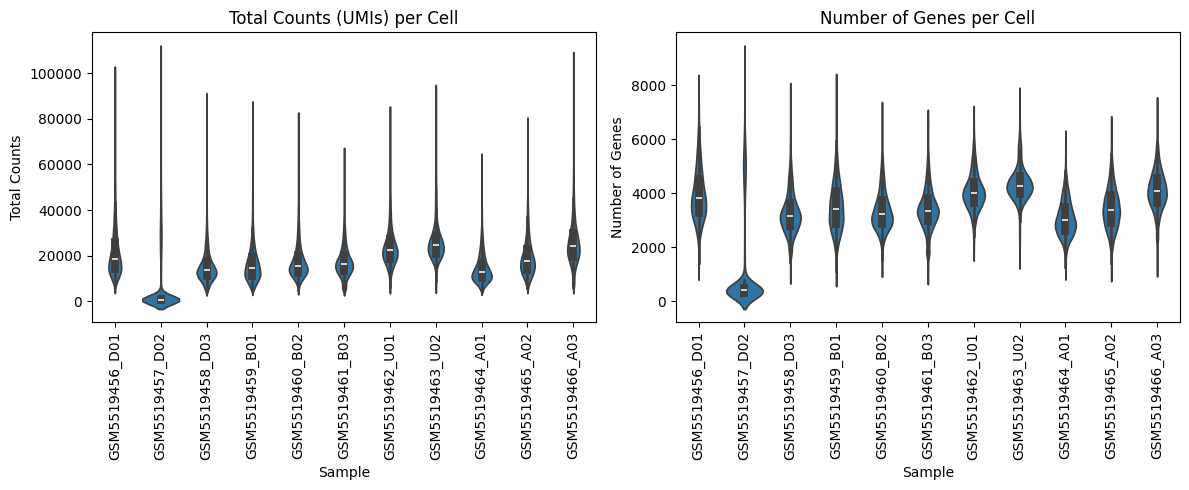

In [7]:
def find_10x_directories(root: Path) -> List[Path]:
    """Finds all valid 10x directories within a given root directory."""
    print(f"[info] Searching for valid 10x directories in {root}...")
    valid_dirs = [d for d in root.iterdir() if d.is_dir() and verify_10x_dir(d)]
    # Also check one level deeper for structures like root/sample_name/matrix_files
    for d in root.iterdir():
        if d.is_dir():
            for sub_d in d.iterdir():
                 if sub_d.is_dir() and verify_10x_dir(sub_d):
                    valid_dirs.append(sub_d)
    
    # Include repacked directories from the previous step
    repacked_dirs = list(root.glob('*_repacked'))
    for d in repacked_dirs:
        if d.is_dir() and verify_10x_dir(d) and d not in valid_dirs:
            valid_dirs.append(d)
            
    print(f"[info] Found {len(valid_dirs)} valid 10x directories.")
    return sorted(list(set(valid_dirs)))

def load_10x_data(tenx_dirs: List[Path]) -> Tuple[List[ad.AnnData], List[str]]:
    """Loads a list of 10x directories into AnnData objects."""
    adatas = []
    sample_names = []
    
    for path in tqdm(tenx_dirs, desc="Loading 10x data"):
        try:
            # Extract a clean sample name from the directory path
            sample_name = path.name.replace('_repacked', '').replace('_filtered_feature_bc_matrix', '')
            
            # Load the data
            adata = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
            adatas.append(adata)
            sample_names.append(sample_name)
            print(f"  -> Loaded '{sample_name}' with {adata.n_obs} cells and {adata.n_vars} genes.")
        except Exception as e:
            print(f"[error] Failed to load {path}: {e}")
            
    return adatas, sample_names

# 1. Find all valid 10x directories in our working root
tenx_directories = find_10x_directories(WORK_ROOT)

# 2. Load the data from these directories
adatas_list, sample_names_list = load_10x_data(tenx_directories)

# 3. Compute and plot QC metrics using the loaded data
if adatas_list:
    compute_and_plot_qc(adatas_list, sample_names_list)
else:
    print("[warning] No data was loaded, so QC plotting is skipped.")

## 4. Check for Mitochondrial Genes

A high fraction of mitochondrial gene expression can be an indicator of stressed or dying cells (a key QC metric). Before calculating the fraction per cell, we first need to identify which genes in our dataset are mitochondrial.

This function inspects a raw `genes.tsv.gz` file to find and list all genes whose symbols start with the standard "MT-" prefix.

In [8]:
def check_mitochondrial_genes(genes_file_path: Path):
    """
    Reads a genes.tsv.gz file and identifies mitochondrial genes.

    Args:
        genes_file_path: Path to the gzipped genes TSV file.
    """
    if not genes_file_path.exists():
        print(f"[error] File not found: {genes_file_path}")
        return

    print(f"[info] Checking for mitochondrial genes in: {genes_file_path.name}")
    
    mt_genes = []
    try:
        with gzip.open(genes_file_path, 'rt') as f:
            for line in f:
                parts = line.strip().split('\t')
                # The gene symbol is typically the second column.
                # We check if it starts with 'MT-' (case-insensitive).
                if len(parts) >= 2 and parts[1].upper().startswith('MT-'):
                    mt_genes.append(parts[1])
    except Exception as e:
        print(f"[error] Could not read or process the file: {e}")
        return

    if mt_genes:
        print(f"  -> Found {len(mt_genes)} mitochondrial genes:")
        print(f"  {', '.join(mt_genes)}")
    else:
        print("  -> No mitochondrial genes found in this file.")

# Define the path to the specific genes file to check
# This file is located within the raw expanded data directory
genes_file_to_check = WORK_ROOT / 'GSM5519456_D01_genes.tsv.gz'

# Run the check
check_mitochondrial_genes(genes_file_to_check)

[info] Checking for mitochondrial genes in: GSM5519456_D01_genes.tsv.gz
  -> Found 13 mitochondrial genes:
  MT-ND1, MT-ND2, MT-CO1, MT-CO2, MT-ATP8, MT-ATP6, MT-CO3, MT-ND3, MT-ND4L, MT-ND4, MT-ND5, MT-ND6, MT-CYB


## 5. Mitochondrial QC Analysis

Now that we've confirmed the presence of mitochondrial genes, we can calculate the fraction of reads from these genes for each cell. A high fraction can indicate cell stress or damage, making it a critical QC metric.

This function will:
1.  Identify mitochondrial genes in each loaded sample.
2.  Calculate `pct_counts_mt`, the percentage of total UMIs from mitochondrial genes.
3.  Visualize the results with scatter plots and violin plots to help identify potential outlier cells or samples.

[info] Calculating and plotting mitochondrial QC metrics...


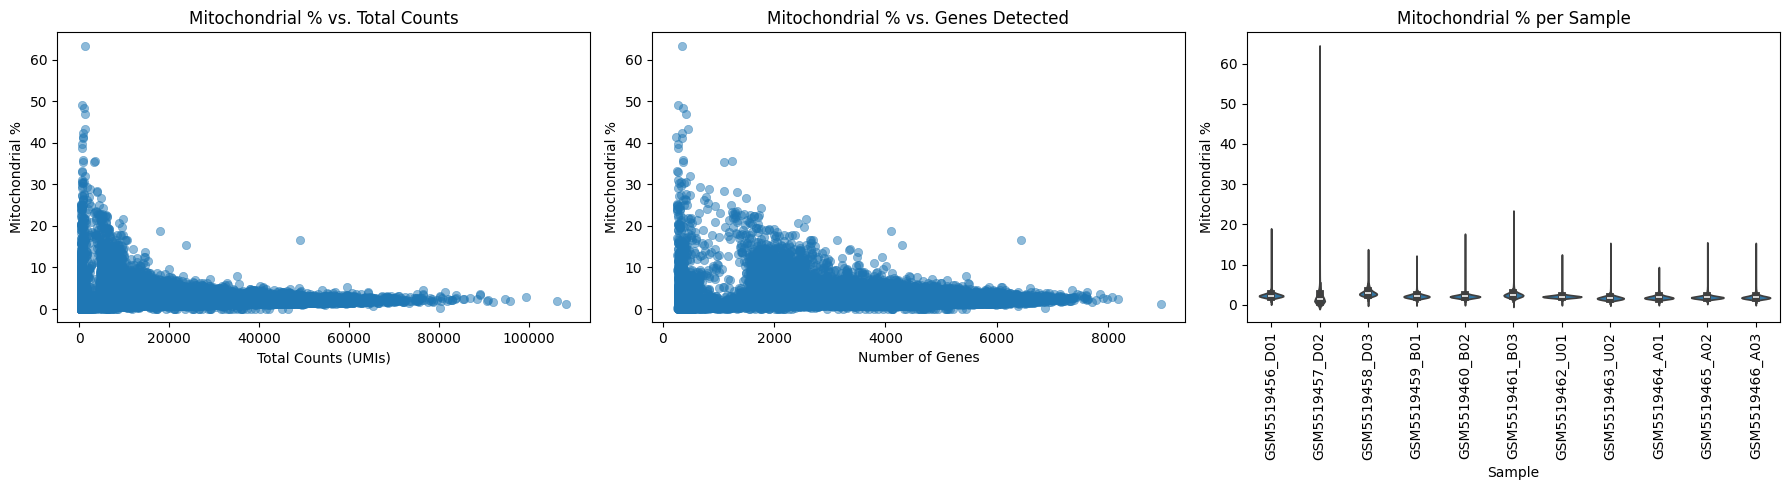

In [9]:
def calculate_and_plot_mito_qc(adatas: List[ad.AnnData], sample_names: List[str]):
    """
    Calculates and visualizes mitochondrial QC metrics.

    Args:
        adatas: A list of AnnData objects that have already had basic QC calculated.
        sample_names: A list of sample names.
    """
    if not adatas:
        print("[warning] No AnnData objects provided; skipping mitochondrial QC.")
        return

    print("[info] Calculating and plotting mitochondrial QC metrics...")

    # 1. Calculate mitochondrial metrics for each AnnData object
    for adata in adatas:
        # Identify mitochondrial genes (case-insensitive)
        adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
        # Calculate QC metrics with mitochondrial gene percentage
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True
        )

    # 2. Concatenate for plotting
    # We assume the adatas still have the 'sample' column from the previous QC step
    combined_adata = ad.concat(adatas, label="sample_id")

    # 3. Create plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot pct_counts_mt vs total_counts
    sns.scatterplot(data=combined_adata.obs, x='total_counts', y='pct_counts_mt', alpha=0.5, ax=axes[0], edgecolor=None)
    axes[0].set_title('Mitochondrial % vs. Total Counts')
    axes[0].set_xlabel('Total Counts (UMIs)')
    axes[0].set_ylabel('Mitochondrial %')

    # Plot pct_counts_mt vs n_genes_by_counts
    sns.scatterplot(data=combined_adata.obs, x='n_genes_by_counts', y='pct_counts_mt', alpha=0.5, ax=axes[1], edgecolor=None)
    axes[1].set_title('Mitochondrial % vs. Genes Detected')
    axes[1].set_xlabel('Number of Genes')
    axes[1].set_ylabel('Mitochondrial %')

    # Violin plot of pct_counts_mt per sample
    sns.violinplot(data=combined_adata.obs, x='sample', y='pct_counts_mt', ax=axes[2])
    axes[2].set_title('Mitochondrial % per Sample')
    axes[2].set_xlabel('Sample')
    axes[2].set_ylabel('Mitochondrial %')
    axes[2].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

# Run the mitochondrial QC analysis on the loaded data
if adatas_list:
    calculate_and_plot_mito_qc(adatas_list, sample_names_list)
else:
    print("[warning] No data was loaded, so mitochondrial QC is skipped.")

## 6. Advanced QC: Low-Gene Cell Counts and Density Visualization

To further scrutinize the data quality, we will perform a few more checks:

1.  **Count Low-Gene Cells**: We'll count the number of cells with fewer than 2000 genes detected. This is a common threshold, and a high number of such cells might indicate a problem with a sample. We will check this both overall and on a per-sample basis.
2.  **Check for Filtered Data**: We'll inspect the number of barcodes (cells) per sample. If the counts are in the thousands (rather than tens or hundreds of thousands), it suggests the data has already been filtered to remove empty droplets, which is typical for 10x Genomics data.
3.  **Density Plot (Hexbin)**: Standard scatter plots can suffer from overplotting, where dense clusters of points obscure the true distribution. A hexbin plot aggregates points into hexagonal bins and colors them by density, providing a clearer view of the relationship between metrics like total UMI counts and the number of detected genes. This helps to confirm if gaps or patterns in the data are real.

[info] Performing advanced QC analysis...

--- Low-Gene Cell Analysis (< 2000 genes) ---
Overall: 11672 of 146426 cells (7.97%) have < 2000 genes.
  - Sample 'GSM5519456_D01': 33 of 9039 cells (0.37%)
  - Sample 'GSM5519457_D02': 9175 of 11000 cells (83.41%)
  - Sample 'GSM5519458_D03': 385 of 11022 cells (3.49%)
  - Sample 'GSM5519459_B01': 359 of 15183 cells (2.36%)
  - Sample 'GSM5519460_B02': 140 of 13732 cells (1.02%)
  - Sample 'GSM5519461_B03': 426 of 10525 cells (4.05%)
  - Sample 'GSM5519462_U01': 20 of 12740 cells (0.16%)
  - Sample 'GSM5519463_U02': 15 of 9861 cells (0.15%)
  - Sample 'GSM5519464_A01': 766 of 24246 cells (3.16%)
  - Sample 'GSM5519465_A02': 297 of 17825 cells (1.67%)
  - Sample 'GSM5519466_A03': 56 of 11253 cells (0.50%)

--- Filtered Matrix Check (Cell Counts) ---
  - Sample 'GSM5519456_D01': 9039 cells (barcodes).
  - Sample 'GSM5519457_D02': 11000 cells (barcodes).
  - Sample 'GSM5519458_D03': 11022 cells (barcodes).
  - Sample 'GSM5519459_B01': 15183 cel

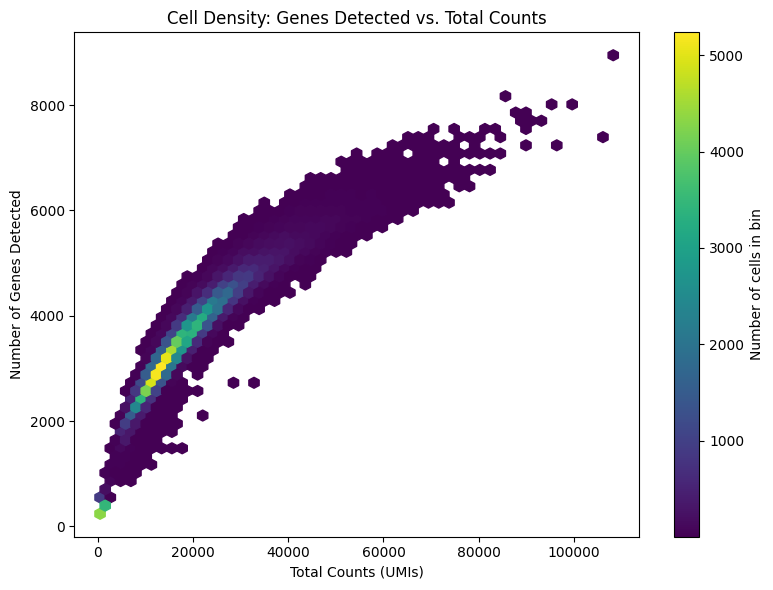

In [10]:
def advanced_qc_analysis(adatas: List[ad.AnnData], sample_names: List[str]):
    """
    Performs advanced QC analysis:
    1. Counts cells with fewer than 2000 genes.
    2. Checks if the matrix appears filtered based on cell counts.
    3. Plots a hexbin of total_counts vs. n_genes_by_counts to show density.
    """
    if not adatas:
        print("[warning] No AnnData objects provided; skipping advanced QC.")
        return

    print("[info] Performing advanced QC analysis...")

    # We assume adatas have 'total_counts' and 'n_genes_by_counts' from previous QC steps
    combined_adata = ad.concat(adatas, label="sample_id", index_unique="-")

    # 1. Count cells with < 2000 genes
    print("\n--- Low-Gene Cell Analysis (< 2000 genes) ---")
    low_gene_threshold = 2000
    
    # Overall
    overall_low_gene_cells = combined_adata.obs['n_genes_by_counts'] < low_gene_threshold
    total_low_gene_count = overall_low_gene_cells.sum()
    total_cells = combined_adata.n_obs
    percentage_low_overall = (total_low_gene_count / total_cells) * 100
    print(f"Overall: {total_low_gene_count} of {total_cells} cells ({percentage_low_overall:.2f}%) have < {low_gene_threshold} genes.")

    # Per sample
    for i, adata in enumerate(adatas):
        sample_name = sample_names[i]
        low_gene_count = (adata.obs['n_genes_by_counts'] < low_gene_threshold).sum()
        sample_total_cells = adata.n_obs
        percentage_low_sample = (low_gene_count / sample_total_cells) * 100
        print(f"  - Sample '{sample_name}': {low_gene_count} of {sample_total_cells} cells ({percentage_low_sample:.2f}%)")

    # 2. Check if matrix is "filtered"
    print("\n--- Filtered Matrix Check (Cell Counts) ---")
    for i, adata in enumerate(adatas):
        print(f"  - Sample '{sample_names[i]}': {adata.n_obs} cells (barcodes).")
    print("If counts are in the thousands, the data is likely pre-filtered.")

    # 3. Plot a hexbin of total_counts vs n_genes_by_counts
    print("\n--- Density Visualization (Hexbin Plot) ---")
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    hb = ax.hexbin(
        x=combined_adata.obs['total_counts'],
        y=combined_adata.obs['n_genes_by_counts'],
        gridsize=50,
        cmap='viridis',
        mincnt=1  # Only show bins with at least one cell
    )
    
    ax.set_title('Cell Density: Genes Detected vs. Total Counts')
    ax.set_xlabel('Total Counts (UMIs)')
    ax.set_ylabel('Number of Genes Detected')
    
    # Add a color bar
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Number of cells in bin')
    
    plt.tight_layout()
    plt.show()

# Run the advanced QC analysis on the loaded data
if adatas_list:
    advanced_qc_analysis(adatas_list, sample_names_list)
else:
    print("[warning] No data was loaded, so advanced QC is skipped.")

## 7. Manual QC Filtering with Power-Law Envelope

After visualizing the QC metrics, we can define a more sophisticated filter than simple thresholds. This section introduces a "manual envelope" method to flag low-quality cells based on their mitochondrial percentage relative to their total counts (or total genes).

The core idea is to define a power-law curve that acts as an upper boundary for acceptable mitochondrial content. Cells that fall above this curve are flagged for removal. This is more flexible than a single `pct_counts_mt` threshold because it allows for higher mitochondrial content in cells with very low UMI counts, which is a common technical artifact.

The function below will:
1.  Define a power-law function: $M(u) = c + a / (u + d)^b$.
2.  Plot the mitochondrial percentage against total counts on a log-log scale.
3.  Overlay the power-law envelope.
4.  Mark cells that are "over the envelope" (i.e., flagged).
5.  Provide a detailed summary of how many cells are flagged, including a breakdown by count depth.
6.  Offer optional "guide points" (quantiles) to help visually position the curve.

You can interactively tune the parameters `c, a, d, b` in the final cell to adjust the curve and see the results instantly.

--- Running Manual Envelope on 'total_counts' ---


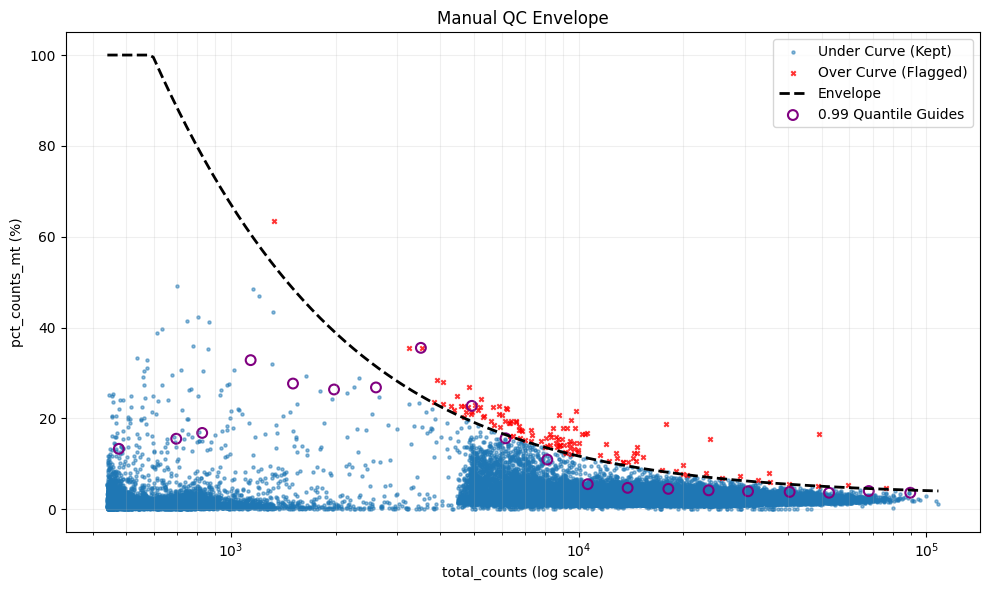

--- QC Envelope Summary ---
Total points analyzed: 146426
Points under curve (kept): 146307
Points over curve (flagged): 119
Overall coverage: 99.92%

--- Coverage by Depth Decile ---
              n_cells  n_flagged coverage
depth_decile                             
0               14644         50   99.66%
1               14643         37   99.75%
2               14641          3   99.98%
3               14646          8   99.95%
4               14643          3   99.98%
5               14641          2   99.99%
6               14642          4   99.97%
7               14642          2   99.99%
8               14642          2   99.99%
9               14642          8   99.95%


--- Running Manual Envelope on 'n_genes_by_counts' ---


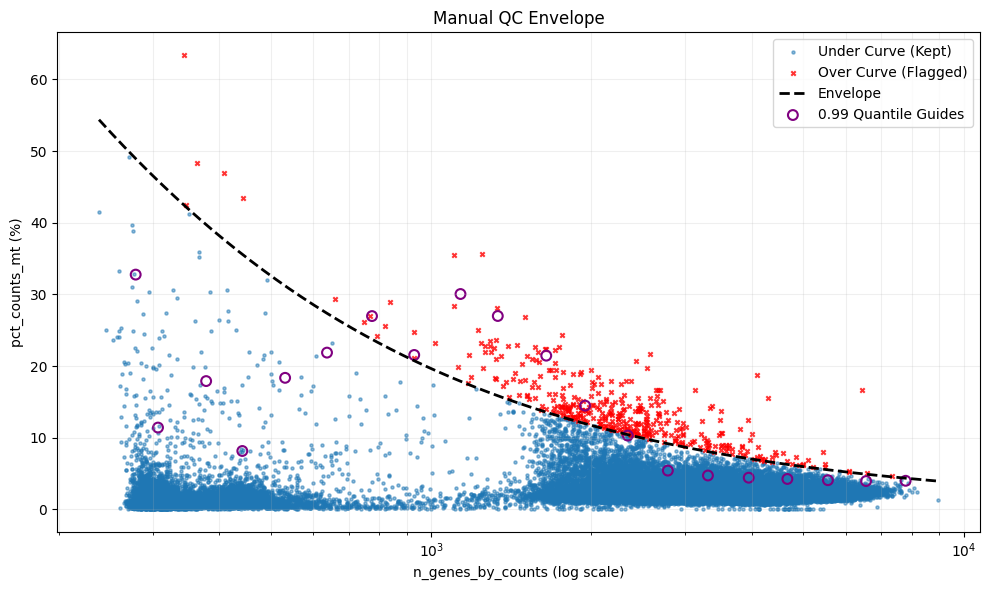

--- QC Envelope Summary ---
Total points analyzed: 146426
Points under curve (kept): 146051
Points over curve (flagged): 375
Overall coverage: 99.74%

--- Coverage by Depth Decile ---
              n_cells  n_flagged coverage
depth_decile                             
0               14651        183   98.75%
1               14661         89   99.39%
2               14657         23   99.84%
3               14651         10   99.93%
4               14649         14   99.90%
5               14633         15   99.90%
6               14617          8   99.95%
7               14652         11   99.92%
8               14618          7   99.95%
9               14637         15   99.90%


In [11]:
def manual_envelope_qc(
    df: pd.DataFrame,
    u_col: str,
    mito_col: str,
    c: float,
    a: float,
    d: float,
    b: float,
    tau: float = 0.99,
    nbins: int = 20,
    show_bins: bool = True
):
    """
    Performs QC filtering using a manual power-law envelope and visualizes the result.

    Args:
        df (pd.DataFrame): The dataframe containing the QC metrics (e.g., adata.obs).
        u_col (str): The column name for total counts or genes (e.g., 'total_counts').
        mito_col (str): The column name for mitochondrial percentage (e.g., 'pct_counts_mt').
        c (float): Baseline for the envelope (raises the right tail).
        a (float): Amplitude of the envelope (raises the left side).
        d (float): Horizontal shift/knee of the envelope.
        b (float): Decay steepness of the envelope.
        tau (float, optional): Quantile for guide points. Defaults to 0.99.
        nbins (int, optional): Number of bins for guide points. Defaults to 20.
        show_bins (bool, optional): Whether to show guide points. Defaults to True.
    """
    # --- 1. Data Preparation ---
    # Work on a copy to avoid modifying the original dataframe
    data = df[[u_col, mito_col]].copy()
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data = data[data[u_col] > 0]

    if data.empty:
        print("[error] No valid data points after filtering for positive u_col and NaNs.")
        return

    # --- 2. Define Envelope and Flag Cells ---
    def power_law_envelope(u, c, a, d, b):
        """Power-law function, clamped to [0, 1]."""
        val = c + a / ((u + d) ** b)
        return np.clip(val, 0, 1)

    data['envelope_val'] = power_law_envelope(data[u_col], c, a, d, b)
    data['flagged'] = (data[mito_col] / 100.0) > data['envelope_val']

    # --- 3. Plotting ---
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for non-flagged and flagged points
    plt.scatter(
        data.loc[~data['flagged'], u_col],
        data.loc[~data['flagged'], mito_col],
        s=5, alpha=0.5, label='Under Curve (Kept)'
    )
    plt.scatter(
        data.loc[data['flagged'], u_col],
        data.loc[data['flagged'], mito_col],
        s=10, marker='x', color='red', alpha=0.8, label='Over Curve (Flagged)'
    )

    # Overlay the envelope line
    u_min, u_max = data[u_col].min(), data[u_col].max()
    u_range = np.logspace(np.log10(u_min), np.log10(u_max), 200)
    envelope_line = 100 * power_law_envelope(u_range, c, a, d, b)
    plt.plot(u_range, envelope_line, color='black', linestyle='--', lw=2, label='Envelope')

    # Optional guide points
    if show_bins:
        data['log10_u'] = np.log10(data[u_col])
        data['bin'] = pd.cut(data['log10_u'], bins=nbins)
        guides = data.groupby('bin').agg(
            u_mid=('log10_u', 'mean'),
            mito_q=(mito_col, lambda x: x.quantile(tau))
        ).dropna()
        plt.scatter(10**guides['u_mid'], guides['mito_q'], s=50, facecolors='none',
                    edgecolors='purple', lw=1.5, label=f'{tau:.2f} Quantile Guides')

    plt.xscale('log')
    plt.xlabel(f'{u_col} (log scale)')
    plt.ylabel(f'{mito_col} (%)')
    plt.title('Manual QC Envelope')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

    # --- 4. Summary Readout ---
    n_total = len(data)
    n_flagged = data['flagged'].sum()
    n_under = n_total - n_flagged
    coverage = n_under / n_total if n_total > 0 else 0

    print("--- QC Envelope Summary ---")
    print(f"Total points analyzed: {n_total}")
    print(f"Points under curve (kept): {n_under}")
    print(f"Points over curve (flagged): {n_flagged}")
    print(f"Overall coverage: {coverage:.2%}")

    # Coverage by depth decile
    print("\n--- Coverage by Depth Decile ---")
    data['depth_decile'] = pd.qcut(np.log10(data[u_col] + 1), 10, labels=False, duplicates='drop')
    decile_summary = data.groupby('depth_decile')['flagged'].agg(['count', 'sum'])
    decile_summary['coverage'] = (1 - (decile_summary['sum'] / decile_summary['count'])).apply('{:.2%}'.format)
    decile_summary.rename(columns={'count': 'n_cells', 'sum': 'n_flagged'}, inplace=True)
    print(decile_summary)


# --- Call the function ---
# Create a combined dataframe from the loaded data if available
if 'adatas_list' in locals() and adatas_list:
    # We assume adatas have been QC'd and concatenated in previous steps
    combined_obs = ad.concat(adatas_list, label="sample_id", index_unique="-").obs
    
    print("--- Running Manual Envelope on 'total_counts' ---")
    # Tweak these parameters to adjust the curve
    manual_envelope_qc(
        df=combined_obs,
        u_col='total_counts',
        mito_col='pct_counts_mt',
        c=0.03, a=350, d=100, b=.9,
        show_bins=True
    )
    
    print("\n\n--- Running Manual Envelope on 'n_genes_by_counts' ---")
    # Tweak these parameters to adjust the curve
    manual_envelope_qc(
        df=combined_obs,
        u_col='n_genes_by_counts',
        mito_col='pct_counts_mt',
        c=0.005, a=50, d=50, b=.8,
        show_bins=True
    )
else:
    print("[warning] 'adatas_list' not found or empty. Skipping manual envelope QC.")

## 8. Manual QC with Linear Scale Visualization

For comparison, the following function provides the same manual envelope QC analysis but visualizes the data on a **linear x-axis**.

While a log scale is often better for visualizing wide-ranging count data, a linear scale can provide a different perspective, especially for understanding the distribution at lower count ranges. All filtering logic and summary statistics remain the same.

--- Running Manual Envelope on 'total_counts' (Linear Scale) ---


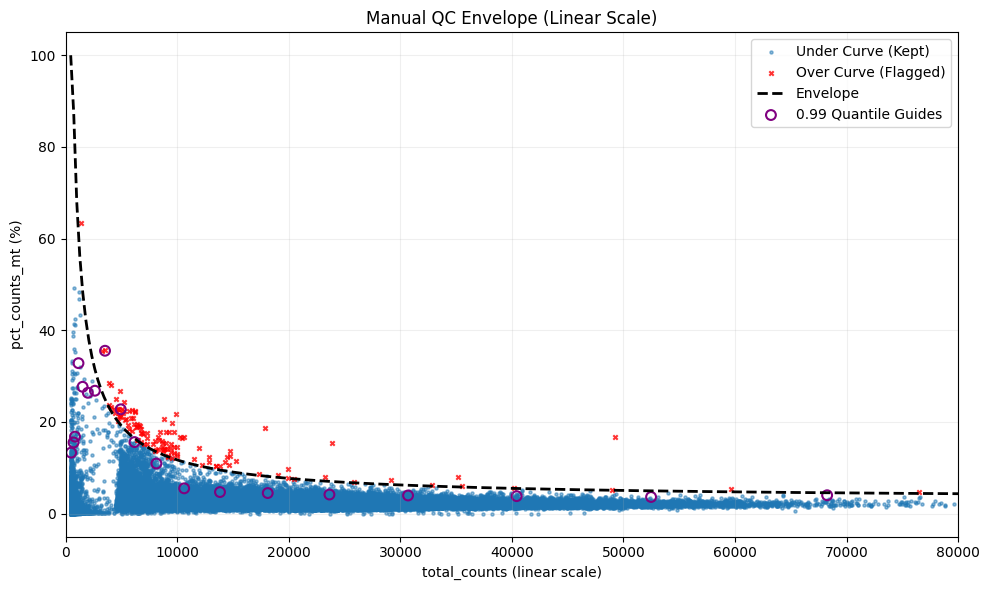

--- QC Envelope Summary ---
Total points analyzed: 146426
Points under curve (kept): 146307
Points over curve (flagged): 119
Overall coverage: 99.92%

--- Coverage by Depth Decile ---
              n_cells  n_flagged coverage
depth_decile                             
0               14644         50   99.66%
1               14643         37   99.75%
2               14641          3   99.98%
3               14646          8   99.95%
4               14643          3   99.98%
5               14641          2   99.99%
6               14642          4   99.97%
7               14642          2   99.99%
8               14642          2   99.99%
9               14642          8   99.95%


--- Running Manual Envelope on 'n_genes_by_counts' (Linear Scale) ---


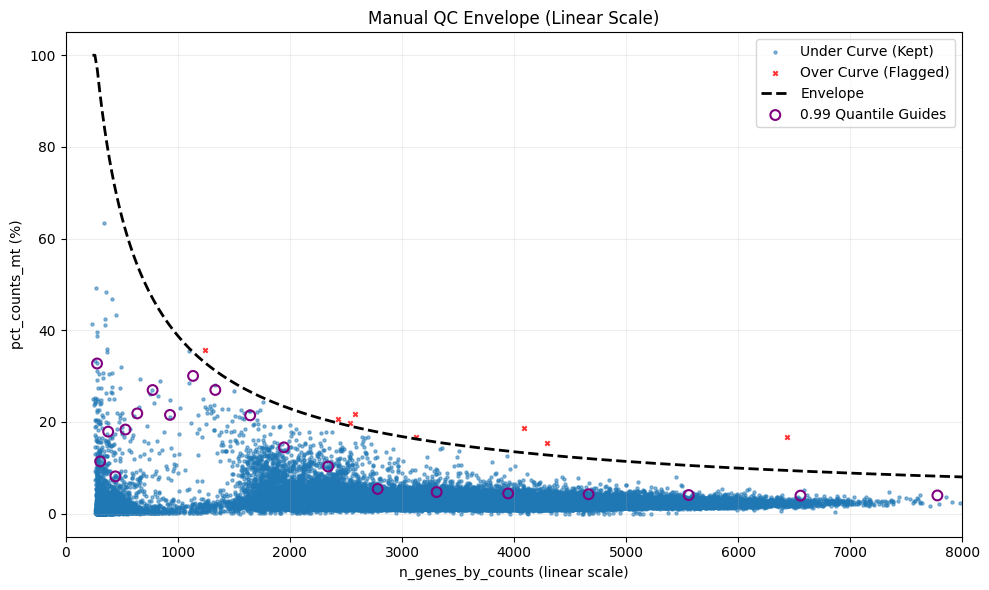

--- QC Envelope Summary ---
Total points analyzed: 146426
Points under curve (kept): 146418
Points over curve (flagged): 8
Overall coverage: 99.99%

--- Coverage by Depth Decile ---
              n_cells  n_flagged coverage
depth_decile                             
0               14651          1   99.99%
1               14661          3   99.98%
2               14657          0  100.00%
3               14651          1   99.99%
4               14649          0  100.00%
5               14633          0  100.00%
6               14617          0  100.00%
7               14652          1   99.99%
8               14618          1   99.99%
9               14637          1   99.99%


In [12]:
def manual_envelope_qc_linear(
    df: pd.DataFrame,
    u_col: str,
    mito_col: str,
    c: float,
    a: float,
    d: float,
    b: float,
    tau: float = 0.99,
    nbins: int = 20,
    show_bins: bool = True,
    xlim_max: int = None
):
    """
    Performs QC filtering using a manual power-law envelope and visualizes the result
    with a LINEAR x-axis.

    Args:
        df (pd.DataFrame): The dataframe containing the QC metrics (e.g., adata.obs).
        u_col (str): The column name for total counts or genes (e.g., 'total_counts').
        mito_col (str): The column name for mitochondrial percentage (e.g., 'pct_counts_mt').
        c (float): Baseline for the envelope (raises the right tail).
        a (float): Amplitude of the envelope (raises the left side).
        d (float): Horizontal shift/knee of the envelope.
        b (float): Decay steepness of the envelope.
        tau (float, optional): Quantile for guide points. Defaults to 0.99.
        nbins (int, optional): Number of bins for guide points. Defaults to 20.
        show_bins (bool, optional): Whether to show guide points. Defaults to True.
        xlim_max (int, optional): The maximum value for the x-axis. Defaults to None.
    """
    # --- 1. Data Preparation ---
    data = df[[u_col, mito_col]].copy()
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data = data[data[u_col] > 0]

    if data.empty:
        print("[error] No valid data points after filtering for positive u_col and NaNs.")
        return

    # --- 2. Define Envelope and Flag Cells ---
    def power_law_envelope(u, c, a, d, b):
        val = c + a / ((u + d) ** b)
        return np.clip(val, 0, 1)

    data['envelope_val'] = power_law_envelope(data[u_col], c, a, d, b)
    data['flagged'] = (data[mito_col] / 100.0) > data['envelope_val']

    # --- 3. Plotting ---
    plt.figure(figsize=(10, 6))
    
    plt.scatter(
        data.loc[~data['flagged'], u_col],
        data.loc[~data['flagged'], mito_col],
        s=5, alpha=0.5, label='Under Curve (Kept)'
    )
    plt.scatter(
        data.loc[data['flagged'], u_col],
        data.loc[data['flagged'], mito_col],
        s=10, marker='x', color='red', alpha=0.8, label='Over Curve (Flagged)'
    )

    # Overlay the envelope line on a linear scale
    u_min, u_max = data[u_col].min(), data[u_col].max()
    u_range = np.linspace(u_min, u_max, 400) # Use linspace for linear plot
    envelope_line = 100 * power_law_envelope(u_range, c, a, d, b)
    plt.plot(u_range, envelope_line, color='black', linestyle='--', lw=2, label='Envelope')

    if show_bins:
        # Binning on log scale is often better due to data distribution, but plot on linear
        data['log10_u'] = np.log10(data[u_col])
        data['bin'] = pd.cut(data['log10_u'], bins=nbins)
        guides = data.groupby('bin').agg(
            u_mid=('log10_u', 'mean'),
            mito_q=(mito_col, lambda x: x.quantile(tau))
        ).dropna()
        plt.scatter(10**guides['u_mid'], guides['mito_q'], s=50, facecolors='none',
                    edgecolors='purple', lw=1.5, label=f'{tau:.2f} Quantile Guides')

    plt.xscale('linear') # Set x-axis to linear
    plt.xlabel(f'{u_col} (linear scale)')
    plt.ylabel(f'{mito_col} (%)')
    plt.title('Manual QC Envelope (Linear Scale)')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    if xlim_max is not None:
        plt.xlim(0, xlim_max)
        
    plt.tight_layout()
    plt.show()

    # --- 4. Summary Readout (Identical to log version) ---
    n_total = len(data)
    n_flagged = data['flagged'].sum()
    n_under = n_total - n_flagged
    coverage = n_under / n_total if n_total > 0 else 0

    print("--- QC Envelope Summary ---")
    print(f"Total points analyzed: {n_total}")
    print(f"Points under curve (kept): {n_under}")
    print(f"Points over curve (flagged): {n_flagged}")
    print(f"Overall coverage: {coverage:.2%}")

    print("\n--- Coverage by Depth Decile ---")
    data['depth_decile'] = pd.qcut(np.log10(data[u_col] + 1), 10, labels=False, duplicates='drop')
    decile_summary = data.groupby('depth_decile')['flagged'].agg(['count', 'sum'])
    decile_summary['coverage'] = (1 - (decile_summary['sum'] / decile_summary['count'])).apply('{:.2%}'.format)
    decile_summary.rename(columns={'count': 'n_cells', 'sum': 'n_flagged'}, inplace=True)
    print(decile_summary)


# --- Call the new linear function ---
if 'adatas_list' in locals() and adatas_list:
    # We assume adatas have been QC'd and concatenated in previous steps
    combined_obs = ad.concat(adatas_list, label="sample_id", index_unique="-").obs
    
    print("--- Running Manual Envelope on 'total_counts' (Linear Scale) ---")
    manual_envelope_qc_linear(
        df=combined_obs,
        u_col='total_counts',
        mito_col='pct_counts_mt',
        c=0.03, a=350, d=100, b=.9,
        show_bins=True,
        xlim_max=80000
    )
    
    print("\n\n--- Running Manual Envelope on 'n_genes_by_counts' (Linear Scale) ---")
    manual_envelope_qc_linear(
        df=combined_obs,
        u_col='n_genes_by_counts',
        mito_col='pct_counts_mt',
        c=0.005, a=100, d=50, b=.8,
        show_bins=True,
        xlim_max=8000
    )
else:
    print("[warning] 'adatas_list' not found or empty. Skipping manual envelope QC.")